In [2]:
import os
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
import pubchempy as pcp
os.chdir('../')
from util.util import *
os.chdir('notebooks')


import IPython.display as Disp

In [47]:
def find_top_mols(pl_data, org_data, org_smiles, best_orgs, scaling_factor=1, return_pca=False):
    rand_idxs = np.random.choice(np.arange(len(pl_data)), size=len(pl_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    
    pl_train = pl_data[train_idxs,:]
    pl_test = pl_data[test_idxs,:]
    
    rand_idxs = np.random.choice(np.arange(len(org_data)), size=len(org_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    org_train = org_data[train_idxs,:]
    org_test = org_data[test_idxs,:]
    org_smiles_test = org_smiles[test_idxs]
    
    train_data = np.concatenate([pl_train, org_train], axis=0)
    test_data = np.concatenate([pl_test, org_test], axis=0)
    
    scaler = MinMaxScaler([0,1*scaling_factor])
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    pca = PCA(n_components=2)
    train_ics = pca.fit_transform(train_data)
    test_ics = pca.transform(test_data)

    pl_ics = train_ics[:168,:]
    org_ics = train_ics[168:,:]
    test_pl_ics = test_ics[:42,:]
    test_org_ics = test_ics[42:,:]
    
    if return_pca:
        return pl_ics, test_pl_ics, org_ics, test_org_ics
    
    pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0], test_org_ics[:,0]], axis=0)
    pc1_min = math.floor(pc1_all.min())
    pc1_max = math.ceil(pc1_all.max())
    pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1], test_org_ics[:,1]], axis=0)
    pc2_min = math.floor(pc2_all.min())
    pc2_max = math.ceil(pc2_all.max())
    
    kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])
    pl_test_kdes = []
    pl_train_kdes = []
    org_kdes = []
    for pl_sample in test_pl_ics:
        pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for pl_sample in pl_ics:
        pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for org_sample in test_org_ics:
        org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))
    
    org_hits_kde_best, org_hits_sm_best = zip(*reversed(sorted(zip(org_kdes, org_smiles_test))))
    for i, smile in enumerate(org_hits_sm_best):
        best_orgs[smile][0] += 1
        best_orgs[smile][1] += org_hits_kde_best[i]
    return best_orgs


def lasso_selection(pl_data, org_data, org_smiles, best_orgs, scaling_factor=1, return_pca=False):
    rand_idxs = np.random.choice(np.arange(len(pl_data)), size=len(pl_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]

    pl_train = pl_data[train_idxs,:]
    pl_test = pl_data[test_idxs,:]

    rand_idxs = np.random.choice(np.arange(len(org_data)), size=len(org_data), replace=False)
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    org_train = org_data[train_idxs,:]
    org_test = org_data[test_idxs,:]
    org_smiles_test = org_smiles[test_idxs]

    train_data = np.concatenate([pl_train, org_train], axis=0)
    test_data = np.concatenate([pl_test, org_test], axis=0)
    np.random.shuffle(train_data)

    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
    sel_.fit(X_train, y_train)
    
    X_train_sel = X_train[:,sel_.get_support()]
    X_test_sel = X_test[:,sel_.get_support()]
    
    pca = PCA(n_components=2)
    train_ics = pca.fit_transform(X_train_sel)
    test_ics = pca.transform(X_test_sel)
    
    pl_ics = train_ics[np.where(y_train == 1)]
    org_ics = train_ics[np.where(y_train == 0)]
    test_pl_ics = test_ics[np.where(y_test == 1)]
    test_org_ics = test_ics[np.where(y_test == 0)]
    
    if return_pca:
        return pl_ics, test_pl_ics, org_ics, test_org_ics
    
    pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0], test_org_ics[:,0]], axis=0)
    pc1_min = math.floor(pc1_all.min())
    pc1_max = math.ceil(pc1_all.max())
    pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1], test_org_ics[:,1]], axis=0)
    pc2_min = math.floor(pc2_all.min())
    pc2_max = math.ceil(pc2_all.max())
    
    kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])
    pl_test_kdes = []
    pl_train_kdes = []
    org_kdes = []
    for pl_sample in test_pl_ics:
        pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for pl_sample in pl_ics:
        pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    for org_sample in test_org_ics:
        org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))
    
    org_hits_kde_best, org_hits_sm_best = zip(*reversed(sorted(zip(org_kdes, org_smiles_test))))
    for i, smile in enumerate(org_hits_sm_best):
        best_orgs[smile][0] += 1
        best_orgs[smile][1] += org_hits_kde_best[i]
    return best_orgs


## Descriptors Only

In [88]:
pl_desc = pd.read_excel('../database/plasticizer_data_v5_rdkit.xls')
pl_desc = pl_desc[pl_desc.columns[1:]]

org_data = pd.read_pickle('../data/pubchem/descriptors/org_chem_pubc.pkl')
org_desc = org_data[~org_data.isin([np.nan, np.inf, -np.inf]).any(1)]
org_desc = org_desc.reset_index(drop=True)

shared_cols = set(pl_desc.columns).intersection(set(org_desc.columns))
shared_cols = shared_cols - set(['SMILES', 'Ipc'])

pl_desc = pl_desc[shared_cols].to_numpy()
org_desc = org_desc[shared_cols].to_numpy()
org_smiles = org_data['SMILES'].to_numpy()

In [89]:
best_orgs = {}
for smile in org_smiles:
    best_orgs[smile] = [0, 0]

In [90]:
pl_ics, test_pl_ics, org_ics, test_org_ics = find_top_mols(pl_desc, org_desc, org_smiles, best_orgs, scaling_factor=0.1, return_pca=True)

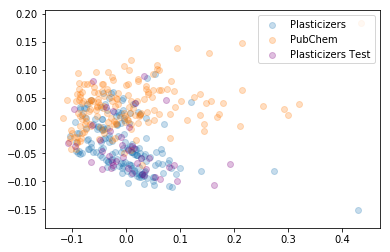

In [96]:
plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(org_ics[:,0], org_ics[:,1], label='PubChem', alpha=0.25)
plt.scatter(test_pl_ics[:,0], test_pl_ics[:,1], label='Plasticizers Test', c='purple', alpha=0.25)
plt.legend()
plt.show()

In [100]:
pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0]], axis=0)
pc1_min = math.floor(pc1_all.min())
pc1_max = math.ceil(pc1_all.max())
pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1]], axis=0)
pc2_min = math.floor(pc2_all.min())
pc2_max = math.ceil(pc2_all.max())

kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])

IndexError: list index out of range

In [101]:
pl_test_kdes = []
pl_train_kdes = []
org_kdes = []
for pl_sample in test_pl_ics:
    pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for pl_sample in pl_ics:
    pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))

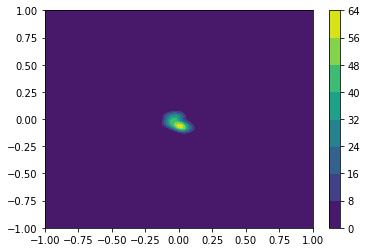

In [102]:
cmap = cm.get_cmap('viridis')
psm = plt.contourf(xs, ys, kde, cmap=cmap)
cbar = plt.colorbar()
plt.show()

In [103]:
normalizer = max(pl_test_kdes)
normalizer

62.320935810342974

In [81]:
best_org_desc = pd.read_pickle('org_ll_analysis/best_orgs_desc.pkl')

In [83]:
top_ten_desc = best_org_desc.iloc[:10,:]
theta_pl = top_ten_desc['Avg. Score'].to_numpy() / normalizer
smiles = top_ten_desc['SMILES'].to_numpy()
urls = []
for hit in smiles:
    url = 'https://cactus.nci.nih.gov/chemical/structure/{}/image'.format(hit)
    urls.append(url)

1.6485152258066265


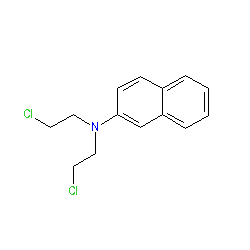

In [84]:
print(theta_pl[0])
Disp.Image(requests.get(urls[0]).content)

## Descriptors Only (LASSO)

In [48]:
pl_desc = pd.read_excel('../database/plasticizer_data_v5_rdkit.xls')
pl_desc = pl_desc[pl_desc.columns[1:]]

org_data = pd.read_pickle('../data/pubchem/descriptors/org_chem_pubc.pkl')
org_desc = org_data[~org_data.isin([np.nan, np.inf, -np.inf]).any(1)]
org_desc = org_desc.reset_index(drop=True)

shared_cols = set(pl_desc.columns).intersection(set(org_desc.columns))
shared_cols = shared_cols - set(['SMILES', 'Ipc'])

pl_desc = pl_desc[shared_cols]
org_desc = org_desc[shared_cols]
ones = np.ones((pl_desc.shape[0],1))
zeros = np.zeros((org_desc.shape[0],1))
pl_desc = np.hstack((pl_desc, ones))
org_desc = np.hstack((org_desc, zeros))
org_smiles = org_data['SMILES'].to_numpy()

In [61]:
best_orgs = {}
for smile in org_smiles:
    best_orgs[smile] = [0, 0]

In [62]:
pl_ics, test_pl_ics, org_ics, test_org_ics = lasso_selection(pl_desc, org_desc, org_smiles, best_orgs, return_pca=True)

/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


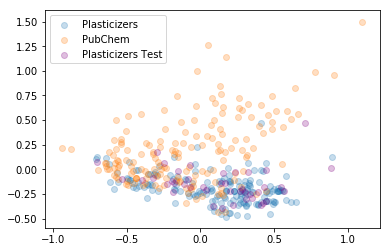

In [63]:
plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(org_ics[:,0], org_ics[:,1], label='PubChem', alpha=0.25)
plt.scatter(test_pl_ics[:,0], test_pl_ics[:,1], label='Plasticizers Test', c='purple', alpha=0.25)
plt.legend()
plt.show()

In [64]:
pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0], test_org_ics[:,0]], axis=0)
pc1_min = math.floor(pc1_all.min())
pc1_max = math.ceil(pc1_all.max())
pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1], test_org_ics[:,1]], axis=0)
pc2_min = math.floor(pc2_all.min())
pc2_max = math.ceil(pc2_all.max())

kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])
pl_test_kdes = []
pl_train_kdes = []
org_kdes = []
for pl_sample in test_pl_ics:
    pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for pl_sample in pl_ics:
    pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for org_sample in test_org_ics:
    org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))

In [65]:
normalizer = max(pl_train_kdes)

In [66]:
normalizer

3.331325471219202

In [67]:
best_orgs_desc_lasso = pd.read_pickle('org_ll_analysis/best_orgs_desc_lasso.pkl')

In [69]:
top_ten_desc_lasso = best_orgs_desc_lasso.iloc[:10,:]
theta_pl = top_ten_desc_lasso['Avg. Score'].to_numpy() / normalizer
smiles = top_ten_desc_lasso['SMILES'].to_numpy()
urls = []
for hit in smiles:
    url = 'https://cactus.nci.nih.gov/chemical/structure/{}/image'.format(hit)
    urls.append(url)

0.21601309515659384


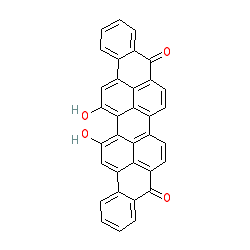

In [70]:
print(theta_pl[0])
Disp.Image(requests.get(urls[0]).content)

0.21385296428202208


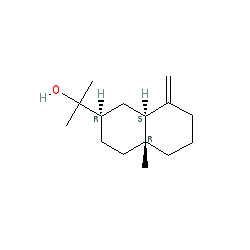

In [71]:
print(theta_pl[1])
Disp.Image(requests.get(urls[1]).content)

0.21385296428202208


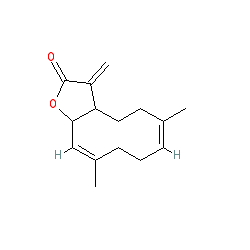

In [72]:
print(theta_pl[2])
Disp.Image(requests.get(urls[2]).content)

0.21361718236173594


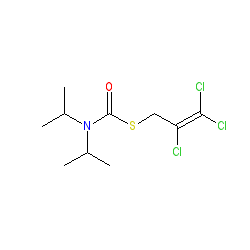

In [73]:
print(theta_pl[3])
Disp.Image(requests.get(urls[3]).content)

0.21306977523185147


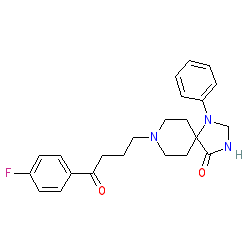

In [74]:
print(theta_pl[4])
Disp.Image(requests.get(urls[4]).content)

## Fingerprints Only

In [3]:
# Load Data
pl_data = pd.read_pickle('../data/pubchem/fingerprints/plasticizer_fingerprints.pkl')
pl_data = pl_data[(pl_data.T != 0).any()]
org_data = pd.read_pickle('../data/pubchem/fingerprints/organic_fingerprints.pkl')
org_data = org_data[(org_data.T != 0).any()]
org_cols = org_data.columns.to_list()
org_cols[0] = 'SMILES'
org_data.columns = org_cols

pl_smiles = pl_data['SMILES'].to_numpy()
pl_fps = pl_data[pl_data.columns[1:]].to_numpy()
org_data = org_data.sample(n=org_data.shape[0])
org_smiles = org_data['SMILES'].to_numpy()
org_fps = org_data[org_data.columns[1:]].to_numpy()

In [5]:
best_orgs = {}
for smile in org_smiles:
    best_orgs[smile] = [0, 0]

In [6]:
pl_ics, test_pl_ics, org_ics, test_org_ics = find_top_mols(pl_fps, org_fps, org_smiles, best_orgs, scaling_factor=0.1, return_pca=True)

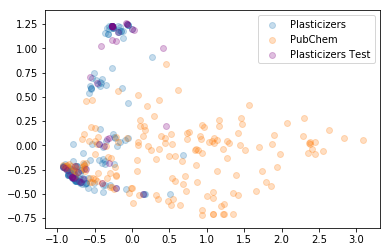

In [9]:
plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(org_ics[:,0], org_ics[:,1], label='PubChem', alpha=0.25)
plt.scatter(test_pl_ics[:,0], test_pl_ics[:,1], label='Plasticizers Test', c='purple', alpha=0.25)
plt.legend()
plt.show()

In [13]:
pc1_all = np.concatenate([pl_ics[:,0], org_ics[:,0], test_pl_ics[:,0], test_org_ics[:,0]], axis=0)
pc1_min = math.floor(pc1_all.min())
pc1_max = math.ceil(pc1_all.max())
pc2_all = np.concatenate([pl_ics[:,1], org_ics[:,1], test_pl_ics[:,1], test_org_ics[:,1]], axis=0)
pc2_min = math.floor(pc2_all.min())
pc2_max = math.ceil(pc2_all.max())

kde, xs, ys = calc_2D_kde(pl_ics, [pc1_min, pc1_max], [pc2_min, pc2_max])
pl_test_kdes = []
pl_train_kdes = []
org_kdes = []
for pl_sample in test_pl_ics:
    pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for pl_sample in pl_ics:
    pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for org_sample in test_org_ics:
    org_kdes.append(get_2D_kde_value(org_sample, kde, xs, ys))

In [19]:
normalizer = max(pl_train_kdes)

In [4]:
best_orgs_fps = pd.read_pickle('org_ll_analysis/best_orgs_fps.pkl')

In [23]:
top_ten_fps = best_orgs_fps.iloc[:10,:]
theta_pl = top_ten_fps['Avg. Score'].to_numpy() / normalizer
smiles = top_ten_fps['SMILES'].to_numpy()
urls = []
for hit in smiles:
    url = 'https://cactus.nci.nih.gov/chemical/structure/{}/image'.format(hit)
    urls.append(url)

0.8886296655084589


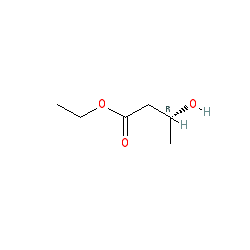

In [29]:
print(theta_pl[0])
Disp.Image(requests.get(urls[0]).content)

0.8885984568324093


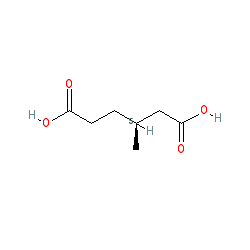

In [30]:
print(theta_pl[1])
Disp.Image(requests.get(urls[1]).content)

0.8885505484923436


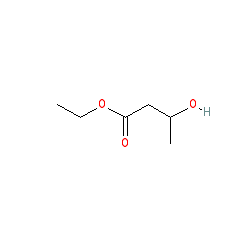

In [31]:
print(theta_pl[2])
Disp.Image(requests.get(urls[2]).content)

0.8884991842906977


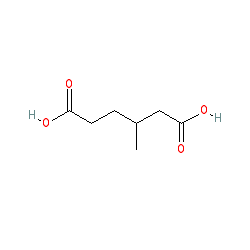

In [32]:
print(theta_pl[3])
Disp.Image(requests.get(urls[3]).content)

0.8880528262480978


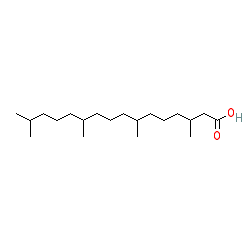

In [33]:
print(theta_pl[4])
Disp.Image(requests.get(urls[4]).content)

0.8880038214801873 C1CCCCOCCCCCCOC(=O)CCC1


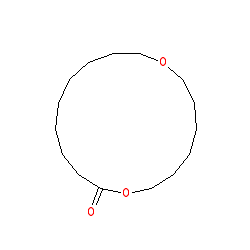

In [36]:
print(theta_pl[5], smiles[5])
Disp.Image(requests.get(urls[5]).content)

0.8879179255288009


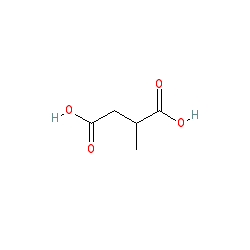

In [35]:
print(theta_pl[6])
Disp.Image(requests.get(urls[6]).content)

0.8878893563680141


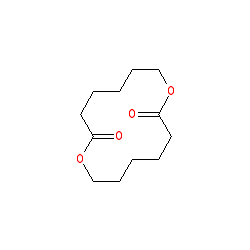

In [37]:
print(theta_pl[7])
Disp.Image(requests.get(urls[7]).content)

In [79]:
pl_data = pd.read_excel('../database/plasticizer_data_v5_rdkit.xls')
pl_data = pl_data[pl_data.columns[1:]]

In [91]:
categories = pl_data['Chemical Category']
le = LabelEncoder()
le.fit(categories.astype(str))
labels = le.transform(categories.astype(str))

In [92]:
labels

array([18, 15, 20, 15,  0,  9, 14,  4,  9,  4, 14, 12, 15,  0,  0,  6, 12,
        3, 15,  0, 12, 15, 19, 24, 22, 11,  6, 15, 22,  9, 12,  4, 15, 15,
        0, 14, 20, 15,  4, 14, 12, 22, 15,  6,  0,  6, 12,  8,  9,  4, 12,
        0, 12,  9, 15,  4, 18, 17, 15,  9, 19,  7,  4, 12, 15, 15,  0, 12,
        9, 14, 16,  9, 12, 12,  9,  0,  4, 14, 12,  9,  9, 15, 15, 16, 22,
       14, 15,  9, 12,  4,  4, 18, 12,  5, 11, 22, 12, 15, 16, 14,  4,  0,
       14,  9, 12, 14, 18, 16, 12, 15, 15,  5, 12, 12,  9,  0, 16, 16, 16,
       12, 15,  5,  9,  4, 15,  4,  2, 15,  0, 12, 12,  9,  6, 15, 15,  9,
        6, 13,  2, 12, 14,  9, 10, 14, 15,  9, 16, 14, 12, 15, 12, 15, 15,
       14, 15, 15, 15, 15, 22,  0, 12, 22, 12, 19,  9, 15, 24, 21,  6, 21,
       12, 15, 12, 12, 22, 18, 15, 11,  8,  8,  0, 18, 11, 28, 27, 24, 26,
       25, 23,  4, 19, 14,  9, 15, 15, 15,  5, 14,  9, 15,  9, 12, 16,  7,
       12, 22, 12, 12,  1, 15])

In [82]:
pl_data['Chemical Category'].value_counts()

Phthalates                     41
Others                         35
Glycols                        23
Phosphates                     16
Benzoates                      14
Adipates                       14
Polymeric plasticizers          9
Trimellitates                   9
Citrates                        7
Sebacates                       6
Chlorinated paraffins           4
Sulfonamides                    4
Oleates                         4
Glutarates                      3
Epoxides                        2
Azelates                        2
Trimelitates                    2
Superplasticizers               2
Alkyl sulfonates                1
Pyromellitates                  1
oleates                         1
Pentaerythritol derivatives     1
Isobutyrates                    1
trimellitates                   1
pyrrolidones                    1
levulinic acid                  1
Benzoate                        1
succinates                      1
Name: Chemical Category, dtype: int64

In [77]:
pl_data = pd.read_pickle('../database/plasticizer_data_v6_desc_fps.pkl')
pl_data = pl_data.drop(['Ipc'], axis=1)
# pl_data = pl_data[pl_data.columns[5:]].to_numpy()
org_data = pd.read_pickle('../data/pubchem/org_desc_fps.pkl')
org_data = org_data[~org_data.isin([np.nan, np.inf, -np.inf]).any(1)]
org_data = org_data.drop(['Ipc'], axis=1)
org_data = org_data[(75 < org_data['MolWt']) & (1500 > org_data['MolWt'])]
org_smiles = org_data['SMILES'].to_numpy()
# org_data = org_data[org_data.columns[1:]].to_numpy()

In [78]:
org_data['MolWt'].min(), org_data['MolWt'].max(), pl_data['MolWt'].min(), pl_data['MolWt'].max()

(75.04299999999999, 1499.6070000000007, 76.095, 1742.5819999999997)

In [63]:
pl_desc = pl_data[:,:199]
pl_fps = pl_data[:,199:]
org_desc = org_data[:,:199]
org_fps = org_data[:,199:]

In [64]:
scale_factor = 0.05
pl_fps = pl_fps*scale_factor
org_fps = org_fps*scale_factor

In [65]:
pl_all = np.concatenate([pl_desc, pl_fps], axis=1)
org_all = np.concatenate([org_desc, org_fps], axis=1)

In [66]:
org_idxs = np.random.choice(np.arange(len(org_all)), size=210, replace=False)
org_train = org_all[org_idxs,:]

train_data = np.concatenate([pl_all, org_train], axis=0)

In [67]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)

In [68]:
train_data.max()

1.0000000000000002

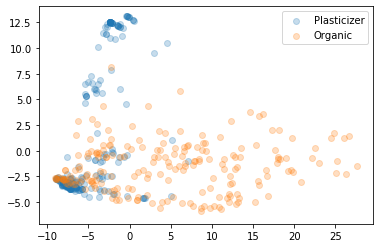

In [69]:
pca = PCA(2)
train_ics = pca.fit_transform(train_data)

plt.scatter(train_ics[:210,0], train_ics[:210,1], label='Plasticizer', alpha=0.25)
plt.scatter(train_ics[210:,0], train_ics[210:,1], label='Organic', alpha=0.25)
plt.legend()
plt.show()